In [1]:
import numpy as np

import pandas as pd

import pymysql as mysql
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns

conn=mysql.connect(host='localhost',port=int(3306),user= 'root',passwd='password',db='retail_database')

In [2]:
# Load the CSV files into DataFrames
df_customer_info = pd.read_csv('/Users/smsultanmahmudrahat/Downloads/department/ADS_last_Project/project/data/customer_info.csv')
df_transactions_details = pd.read_csv('/Users/smsultanmahmudrahat/Downloads/department/ADS_last_Project/project/data/transaction_details.csv')
df_transaction_logistics = pd.read_csv('/Users/smsultanmahmudrahat/Downloads/department/ADS_last_Project/project/data/transaction_logistics.csv')
df_product_info = pd.read_csv('/Users/smsultanmahmudrahat/Downloads/department/ADS_last_Project/project/data/product_info.csv')
df_feedback = pd.read_csv('/Users/smsultanmahmudrahat/Downloads/department/ADS_last_Project/project/data/feedback.csv')
df_data_clean = pd.read_csv('/Users/smsultanmahmudrahat/Downloads/department/ADS_last_Project/project/retail_data_clean.csv')

In [3]:
import pandas as pd
from sqlalchemy import create_engine

# Database connection details
db_username = 'root'
db_password = 'password'
db_host = 'localhost'  # e.g., 'localhost'
db_database = 'retail_database'  # Database name


# Create a connection to the database
engine = create_engine(f'mysql+pymysql://{db_username}:{db_password}@{db_host}/{db_database}')

# Insert data into the tables
df_customer_info.to_sql('customer_info', con=engine, if_exists='append', index=False)
print("Data inserted successfully.")


Data inserted successfully.


In [33]:
# Function to parse dates with multiple formats
def parse_dates(date_str):
    for fmt in ('%m/%d/%Y', '%m/%d/%y'):
        try:
            return pd.to_datetime(date_str, format=fmt)
        except ValueError:
            pass
    raise ValueError(f"no valid date format found for {date_str}")
df_transactions_details['Date'] = df_transactions_details['Date'].apply(parse_dates).dt.strftime('%Y-%m-%d')


In [36]:
df_transactions_details.to_sql('transactions_details', con=engine, if_exists='append', index=False)


300749

In [37]:
df_transaction_logistics.to_sql('transaction_logistics', con=engine, if_exists='replace', index=False)

300749

In [39]:
df_product_info.to_sql('product_info', con=engine, if_exists='append', index=False)

300749

In [ ]:
df_feedback.to_sql('feedback', con=engine, if_exists='replace', index=False)

In [4]:
from sqlalchemy import create_engine, text
# Function to execute SQL queries and print results
def execute_query(engine, query):
    with engine.connect() as conn:
        result = conn.execute(text(query))
        for row in result:
            print(row)

# List of verification queries
queries = [
    "SHOW TABLES IN retail_database;",
    "SELECT * FROM customer_info LIMIT 10;",
    "SELECT * FROM transactions_details LIMIT 10;",
    "SELECT * FROM transaction_logistics LIMIT 10;",
    "SELECT * FROM product_info LIMIT 10;",
    "SELECT * FROM feedback LIMIT 10;",
    """
    SELECT td.*, ci.Name, ci.Email
    FROM transactions_details td
    JOIN customer_info ci ON td.Customer_ID = ci.Customer_ID
    LIMIT 10;
    """,
    """
    SELECT tl.*, td.Date, td.Amount
    FROM transaction_logistics tl
    JOIN transactions_details td ON tl.Transaction_ID = td.Transaction_ID
    LIMIT 10;
    """,
    """
    SELECT fb.*, pi.Product_Category, pi.Product_Brand
    FROM feedback fb
    JOIN product_info pi ON fb.Product_ID = pi.Product_ID
    LIMIT 10;
    """,
    """
    SELECT fb.*, ci.Name, ci.Email
    FROM feedback fb
    JOIN customer_info ci ON fb.Customer_ID = ci.Customer_ID
    LIMIT 10;
    """
]

# Execute and print results for each query
for query in queries:
    try:
        print(f"Executing query: {query}")
        execute_query(engine, query)
        print("\n")
    except Exception as e:
        print(f"Error executing query: {query}")
        print(e)
        print("\n")


Executing query: SHOW TABLES IN retail_database;
('customer_info',)
('feedback',)
('product_info',)
('transaction_logistics',)
('transactions_details',)


Executing query: SELECT * FROM customer_info LIMIT 10;
(1, 37249, 'Michelle Harrington', 'Ebony39@gmail.com', '1414786801', '3959 Amanda Burgs', 'Dortmund', 'Berlin', '77985', 'Germany', 21, 'Male', 'Low', 'Regular')
(2, 69749, 'Kelsey Hill', 'Mark36@gmail.com', '6852899987', '82072 Dawn Centers', 'Nottingham', 'England', '99071', 'UK', 19, 'Female', 'Low', 'Premium')
(3, 30192, 'Scott Jensen', 'Shane85@gmail.com', '8362160449', '4133 Young Canyon', 'Geelong', 'New South Wales', '75929', 'Australia', 48, 'Male', 'Low', 'Regular')
(4, 62101, 'Joseph Miller', 'Mary34@gmail.com', '2776751724', '8148 Thomas Creek Suite 100', 'Edmonton', 'Ontario', '88420', 'Canada', 56, 'Male', 'High', 'Premium')
(5, 27901, 'Debra Coleman', 'Charles30@gmail.com', '9098267635', '5813 Lori Ports Suite 269', 'Bristol', 'England', '48704', 'UK', 22, 'Male', 

In [ ]:
query = """
SHOW TABLES IN retail_database;
"""
df = pd.read_sql(query,conn)

In [12]:
def query_to_dataframe(engine, query):
    with engine.connect() as conn:
        result = conn.execute(text(query))
        df = pd.DataFrame(result.fetchall(), columns=result.keys())
    return df

# The SQL query to retrieve table and column information
query = """
-- Step 1: Calculate the average total amount spent by all customers
WITH avg_total_amount AS (
    SELECT AVG(Total_Amount) AS avg_amount
    FROM transactions_details
),

-- Step 2: Select female customers with purchases greater than the average
female_customers_above_avg AS (
    SELECT 
        ci.Name,
        ci.City,
        ci.Email,
        ci.Phone,
        td.Transaction_ID,
        td.Total_Amount
    FROM 
        customer_info ci
    JOIN 
        transactions_details td ON ci.Customer_ID = td.Customer_ID
    WHERE 
        ci.Gender = 'Female'
        AND td.Total_Amount > (SELECT avg_amount FROM avg_total_amount)
)

-- Step 3: Retrieve the results
SELECT 
    City,
    COUNT(Name) AS number_of_female_customers,
    SUM(Total_Amount) AS total_amount_spent
FROM 
    female_customers_above_avg
GROUP BY 
    City
ORDER BY 
    total_amount_spent DESC;
"""

# Execute the query and return the result as a DataFrame
df = query_to_dataframe(engine, query)

# Display the DataFrame
#import ace_tools as tools; tools.display_dataframe_to_user(name="Female Customers Above Average Spending", dataframe=df)

df.head()


,City,number_of_female_customers,total_amount_spent
0,Chicago,29356,73308610.58
1,Portsmouth,27508,68863893.26
2,Frankfurt,13750,34568800.70
3,Boston,13416,33283483.32
4,San Francisco,8640,21785261.06


In [13]:
df.to_csv("/Users/smsultanmahmudrahat/Downloads/department/ADS_last_Project/project/sql_to_analysis.csv")

In [14]:
df_customer_info.head()

,Customer_ID,Name,Email,Phone,Address,City,State,Zipcode,Country,Age,Gender,Income,Customer_Segment
0,37249.0,Michelle Harrington,Ebony39@gmail.com,1.414787e+09,3959 Amanda Burgs,Dortmund,Berlin,77985.0,Germany,21.0,Male,Low,Regular
1,69749.0,Kelsey Hill,Mark36@gmail.com,6.852900e+09,82072 Dawn Centers,Nottingham,England,99071.0,UK,19.0,Female,Low,Premium
2,30192.0,Scott Jensen,Shane85@gmail.com,8.362160e+09,4133 Young Canyon,Geelong,New South Wales,75929.0,Australia,48.0,Male,Low,Regular
3,62101.0,Joseph Miller,Mary34@gmail.com,2.776752e+09,8148 Thomas Creek Suite 100,Edmonton,Ontario,88420.0,Canada,56.0,Male,High,Premium
4,27901.0,Debra Coleman,Charles30@gmail.com,9.098268e+09,5813 Lori Ports Suite 269,Bristol,England,48704.0,UK,22.0,Male,Low,Premium


In [65]:
sql_df = pd.read_csv ("/Users/smsultanmahmudrahat/Downloads/department/ADS_last_Project/project/sql_to_analysis.csv")
sql_df.head()

,Unnamed: 0,TABLE_NAME,COLUMN_NAME,DATA_TYPE,CONSTRAINT_TYPE
0,0,customer_info,Address,varchar,NaN
1,1,customer_info,Age,int,NaN
2,2,customer_info,City,varchar,NaN
3,3,customer_info,Country,varchar,NaN
4,4,customer_info,Customer_ID,int,NaN


In [66]:
sql_df

,Unnamed: 0,TABLE_NAME,COLUMN_NAME,DATA_TYPE,CONSTRAINT_TYPE
0,0,customer_info,Address,varchar,NaN
1,1,customer_info,Age,int,NaN
2,2,customer_info,City,varchar,NaN
3,3,customer_info,Country,varchar,NaN
4,4,customer_info,Customer_ID,int,NaN
5,5,customer_info,Customer_Segment,varchar,NaN
6,6,customer_info,Email,varchar,NaN
7,7,customer_info,Gender,varchar,NaN
8,8,customer_info,id,int,PK
9,9,customer_info,Income,varchar,NaN


In [5]:
query = """
SELECT 
    ci.Customer_ID,
    ci.Age,
    ci.Gender,
    ci.Income,
    ci.City,
    ci.State,
    ci.Country,
    tb.Total_Purchases,
    tb.Total_Spent
FROM 
    customer_info ci
JOIN 
    (SELECT 
        td.Customer_ID,
        COUNT(td.Transaction_ID) AS Total_Purchases,
        SUM(td.Total_Amount) AS Total_Spent
     FROM 
        transactions_details td
     GROUP BY 
        td.Customer_ID) tb
ON 
    ci.Customer_ID = tb.Customer_ID;

"""

def query_to_dataframe(engine, query):
    with engine.connect() as conn:
        result = conn.execute(text(query))
        df = pd.DataFrame(result.fetchall(), columns=result.keys())
    return df



# execute the query and returning the result 
df = query_to_dataframe(engine, query)

# first few rows
df.head()


,Customer_ID,Age,Gender,Income,City,State,Country,Total_Purchases,Total_Spent
0,10000,26,Male,High,San Francisco,Maine,USA,8,10015.14
1,10000,26,Male,Medium,Phoenix,North Carolina,USA,8,10015.14
2,10000,64,Female,Low,San Antonio,Nevada,USA,8,10015.14
3,10000,22,Male,Low,Hamburg,Berlin,Germany,8,10015.14
4,10000,26,Male,High,San Francisco,Maine,USA,8,10015.14


In [6]:
df["Country"].value_counts()

USA          189652
UK           125552
Germany      105200
Australia     90322
Canada        90232
Unknown         540
Name: Country, dtype: int64

### Number of Retires across different state in USA

The frequency of retries outside of the USA is huge, which is why we have separated the visualization into two categories: Inside USA and Outside USA.


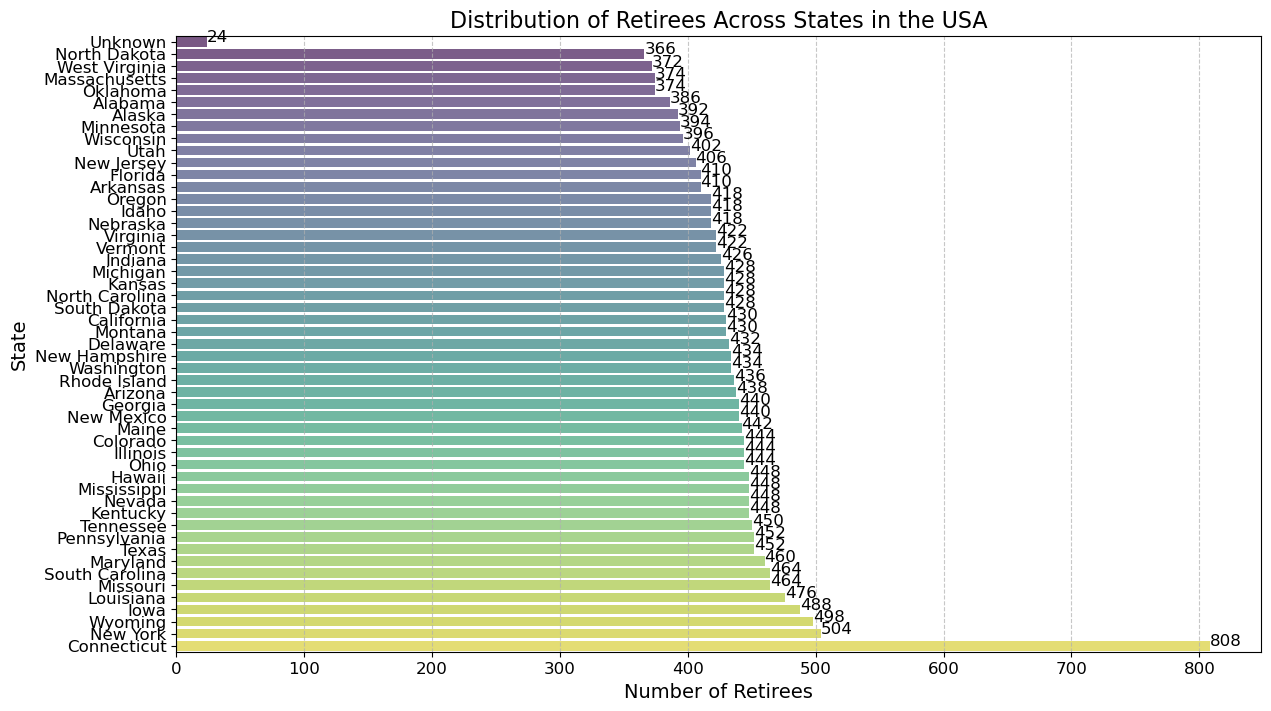

In [8]:
# Filter for Retirees (Age 51+) in the USA
retirees_usa = df[(df['Age'] > 50) & (df['Country'] == 'USA')]

# Plot the distribution of Retirees across States
plt.figure(figsize=(14, 8))
state_counts = retirees_usa['State'].value_counts().sort_values(ascending=True)
sns.barplot(x=state_counts.values, y=state_counts.index, palette="viridis", alpha=0.7)
plt.title('Distribution of Retirees Across States in the USA', fontsize=16)
plt.xlabel('Number of Retirees', fontsize=14)
plt.ylabel('State', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Adding value labels
for index, value in enumerate(state_counts.values):
    plt.text(value, index, str(value), color='black', ha="left", fontsize=12)

plt.show()

### Number of Retires across different state outside USA

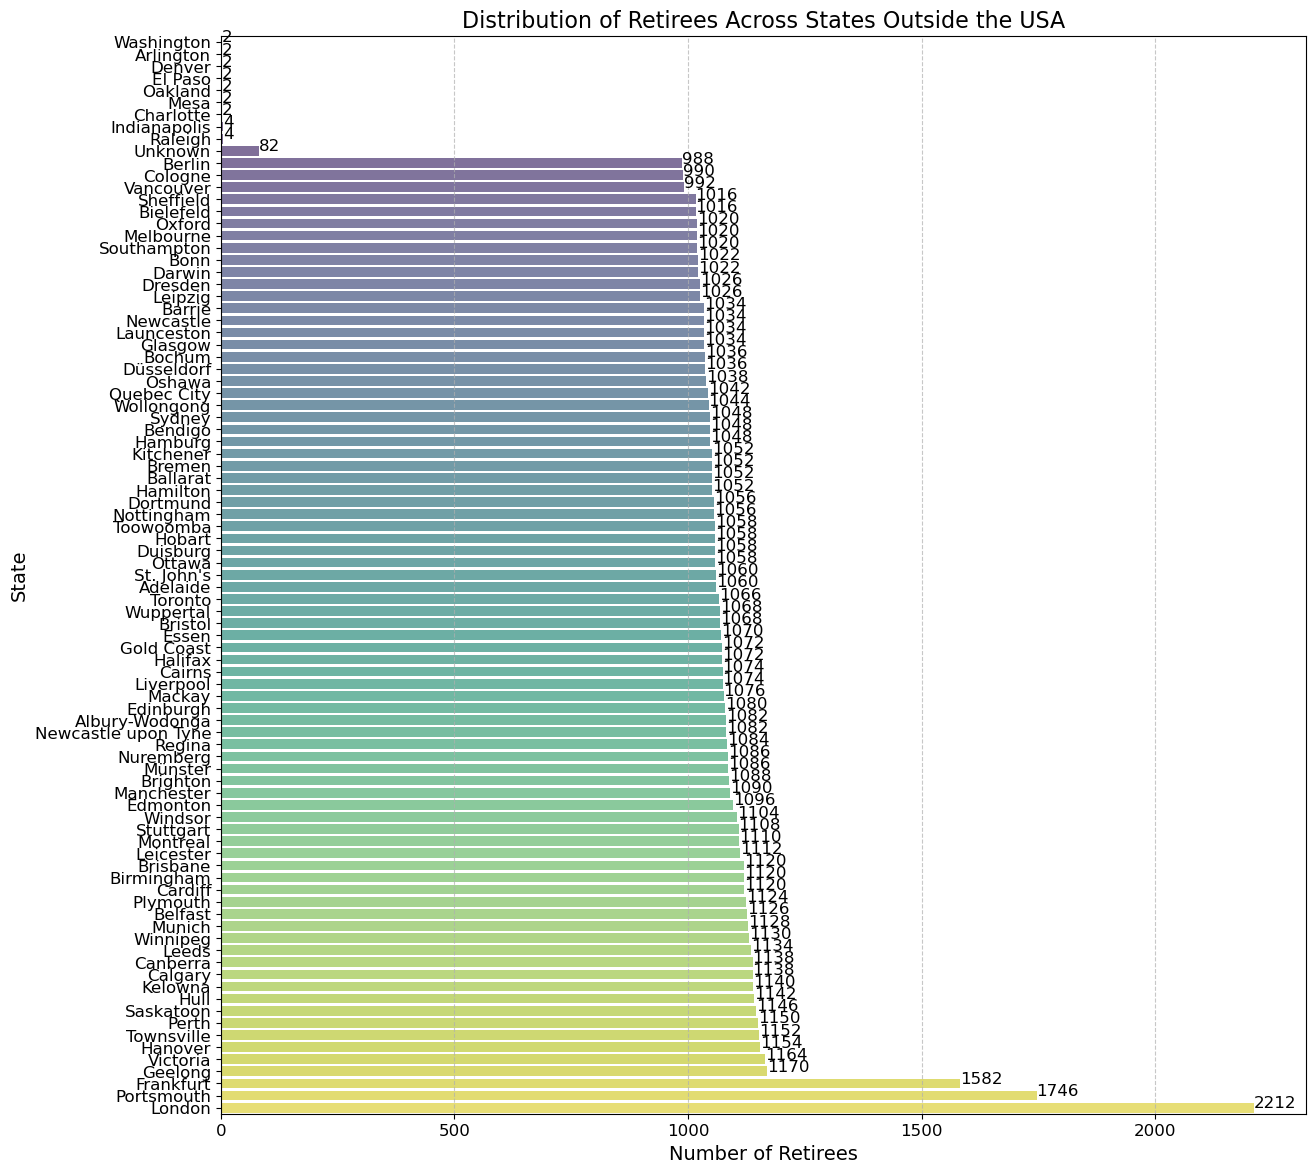

In [9]:
# Filter for Retirees (Age 51+) outside the USA
retirees_non_usa = df[(df['Age'] > 50) & (df['Country'] != 'USA')]

# Plot the distribution of Retirees across Cities
plt.figure(figsize=(14, 14))
city_counts = retirees_non_usa['City'].value_counts().sort_values(ascending=True)
sns.barplot(x=city_counts.values, y=city_counts.index, palette="viridis", alpha=0.7)
plt.title('Distribution of Retirees Across States Outside the USA', fontsize=16)
plt.xlabel('Number of Retirees', fontsize=14)
plt.ylabel('State', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Adding value labels
for index, value in enumerate(city_counts.values):
    plt.text(value, index, str(value), color='black', ha="left", fontsize=12)

plt.show()

### Distribution of middle aged frequent buyer

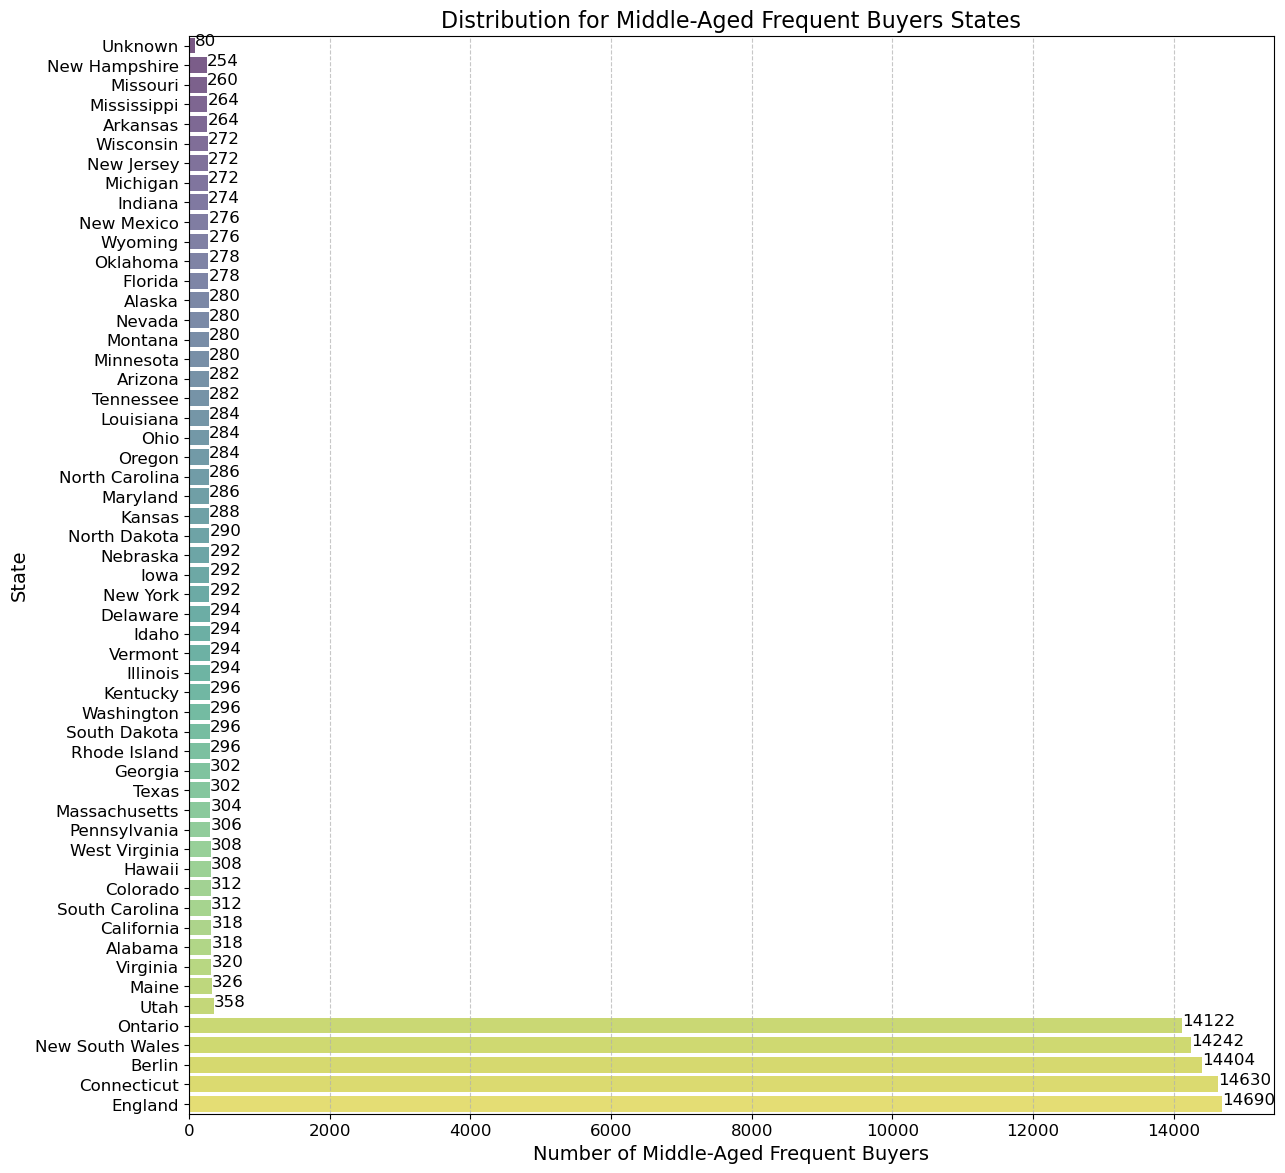

In [10]:
high_purchases_threshold = df[df['Age'].between(31, 50)]['Total_Purchases'].mean()

middle_aged_frequent_buyers_usa = df[(df['Age'].between(31, 50)) & (df['Total_Purchases'] > high_purchases_threshold)]

# Plot the distribution of Retirees across Cities
plt.figure(figsize=(14, 14))
city_counts = middle_aged_frequent_buyers_usa['State'].value_counts().sort_values(ascending=True)
sns.barplot(x=city_counts.values, y=city_counts.index, palette="viridis", alpha=0.7)
plt.title('Distribution for Middle-Aged Frequent Buyers States', fontsize=16)
plt.xlabel('Number of Middle-Aged Frequent Buyers', fontsize=14)
plt.ylabel('State', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)


# Adding value labels
for index, value in enumerate(city_counts.values):
    plt.text(value, index, str(value), color='black', ha="left", fontsize=12)

plt.show()

## Distribution young high spenders

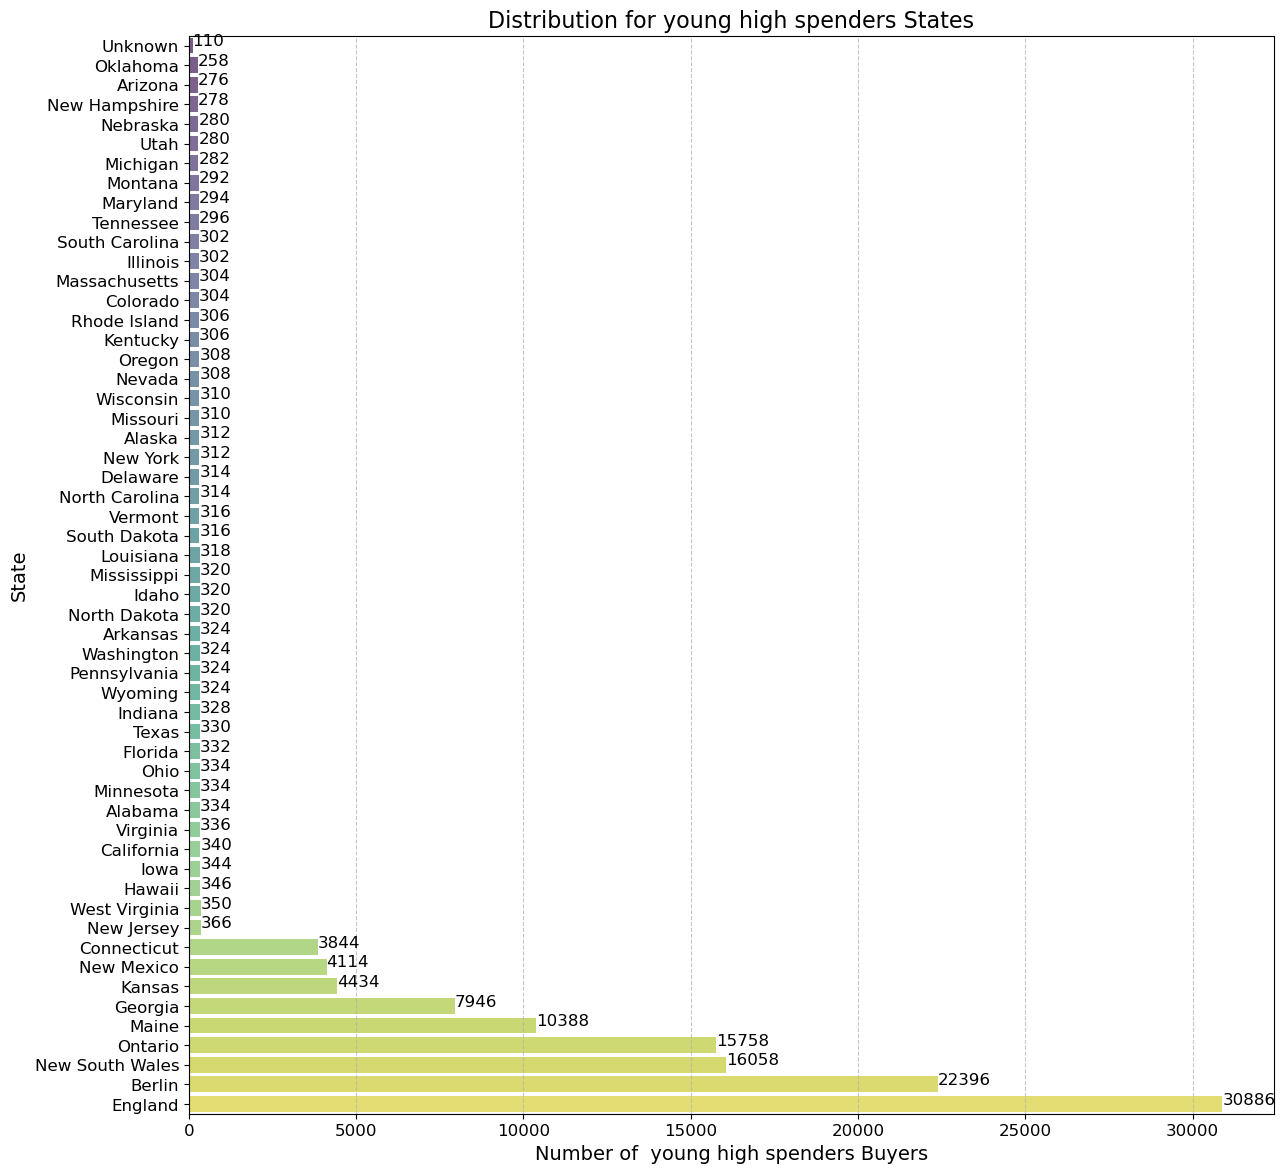

In [11]:
# Define High Total Spent Threshold (e.g., above the mean)
high_spent_threshold = df[df['Age'].between(18, 30)]['Total_Spent'].mean()

# Filter for Young High Spenders
young_high_spenders = df[(df['Age'].between(18, 30)) & (df['Total_Spent'] > high_spent_threshold)]

# Plot the distribution of Retirees across Cities
plt.figure(figsize=(14, 14))
city_counts = young_high_spenders['State'].value_counts().sort_values(ascending=True)
sns.barplot(x=city_counts.values, y=city_counts.index, palette="viridis", alpha=0.7)
plt.title('Distribution for young high spenders States', fontsize=16)
plt.xlabel('Number of  young high spenders Buyers', fontsize=14)
plt.ylabel('State', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Adding value labels
for index, value in enumerate(city_counts.values):
    plt.text(value, index, str(value), color='black', ha="left", fontsize=12)

We have seperated three groups  based on their demographics, behavioral and geopraphy. 

### **Customer Segmentation Analysis**

#### **Objective**: Identify distinct customer segments to target with personalized advertisements.

#### **Strategy**:

1. **Demographics**: Segment customers by age, gender, and income.
2. **Geographic**: Segment customers by city, state, or country.
3. **Behavioral**: Segment customers by their purchasing behavior (like: frequent buyers, high spenders, or occasional shoppers)

We have segmented the database with five types of buyers. 

1. **Young High Spenders** 
2. **Middle-Aged Frequent Buyers**
3. **Retirees in Specific Regions**
4. **Low-Income Customers with High Engagement**
5. **Geographic Campaigns**

We have also segmented the customers according to their geophraphy. We have segemented them into two types.
1. ** Inside USA ** 
2. ** Outside USA ** 

We have seen that, there are differences in purchasing capabilities, cultural differences, and age distribution differences in these two regions. That's why for making the marketing champaign successful, we have tried to use different marketing strategy to these customers. 

### **Segmentation and Targeting Strategies**:

1. **Young High Spenders**:
   - **Criteria**: Age 18-30, High Total_Spent.
   - **Strategy**: Promote luxury and trendy products.

2. **Middle-Aged Frequent Buyers**:
   - **Criteria**: Age 31-50, High Total_Purchases.
   - **Strategy**: Offer loyalty programs and bundle deals.

3. **Retirees in Specific Regions**:
   - **Criteria**: Age 51+, specific cities or states.
   - **Strategy**: Advertise health and wellness products, local events.

4. **Low-Income Customers with High Engagement**:
   - **Criteria**: Low Income, High Total_Purchases.
   - **Strategy**: Provide discounts and budget-friendly product suggestions.

5. **Geographic Campaigns**:
   - **Criteria**: Customers from high-sales cities or regions.
   - **Strategy**: Localized advertising campaigns and region-specific promotions.

By following these steps, we can effectively segment the customer base and tailor marketing strategies to different groups, maximizing the impact of advertising efforts. This approach leverages demographic, geographic, and behavioral data to create highly targeted and personalized marketing campaigns.


In [12]:
# Aggregate total sales by City
city_sales = df.groupby('City')['Total_Spent'].sum().sort_values(ascending=False)
print(city_sales)

# Aggregate total sales by State
state_sales = df.groupby('State')['Total_Spent'].sum().sort_values(ascending=False)
print(state_sales)

City
Chicago          509125449.76
Portsmouth       473989076.52
San Francisco    290242737.72
Frankfurt        239960437.20
Boston           220944046.28
                     ...     
Arlington         20251205.00
Charlotte         20163476.00
Philadelphia      20082093.64
San Diego         20080741.56
Unknown            5789742.16
Name: Total_Spent, Length: 131, dtype: object
State
England            1493242317.36
Berlin             1251705054.88
New South Wales    1076663700.88
Ontario            1073650183.48
Connecticut         509212371.00
Maine               290701216.40
Georgia             223897713.28
Kansas              130030415.92
New Mexico          123573738.40
Iowa                 23268073.12
New York             22965570.04
Texas                22798207.88
West Virginia        22623373.00
Ohio                 22452504.64
Hawaii               22321125.60
Pennsylvania         22275614.60
Missouri             22265536.68
California           22261828.64
Virginia           

In [13]:
# Filter DataFrame for high-sales cities 
top_cities = city_sales.head(10).index
df_top_cities = df[df['City'].isin(top_cities)]

# Demographic breakdown for top cities
demographic_analysis = df_top_cities.groupby('City').agg({
    'Age': ['mean', 'median'],
    'Gender': pd.Series.value_counts, 
    'Income': pd.Series.value_counts
}).reset_index()

print(demographic_analysis)


            City        Age                     Gender                Income
                       mean median        value_counts          value_counts
0         Boston  24.445522   23.0   [11178, 7566, 16]     [17416, 712, 632]
1        Chicago  31.901725   34.0  [26080, 16994, 50]  [17560, 16998, 8566]
2      Edinburgh  38.874405   38.0    [2926, 1680, 12]     [1940, 1688, 990]
3     Fort Worth  22.584716   19.0    [6238, 4110, 16]    [4866, 2974, 2524]
4      Frankfurt  27.144111   22.0   [12420, 7830, 26]   [15684, 2778, 1814]
5         London  39.384235   40.0     [5484, 3416, 6]    [3842, 3332, 1732]
6       New York  25.698784   23.0     [6470, 4382, 4]     [5910, 4208, 738]
7     Portsmouth  23.710370   20.0  [24220, 15798, 40]   [34024, 3912, 2122]
8  San Francisco  26.656590   26.0    [19498, 4774, 8]     [22866, 734, 680]
9       Winnipeg  38.733945   39.0     [2886, 1906, 4]     [2048, 1794, 954]


In [14]:
# filter less sale cities for
less_sales_cities = city_sales.tail(10).index
df_less_sales_cities = df[df['City'].isin(less_sales_cities)]

# Demographic breakdown for top cities
demographic_analysis = df_less_sales_cities.groupby('City').agg({
    'Age': ['mean', 'median'],
    'Gender': pd.Series.value_counts,
    'Income': pd.Series.value_counts
}).reset_index()

print(demographic_analysis)

           City        Age                 Gender           Income
                      mean median    value_counts     value_counts
0     Arlington  39.048066   40.0  [1082, 620, 4]  [676, 656, 374]
1     Charlotte  38.516919   38.0  [1048, 662, 4]  [706, 662, 346]
2        Denver  38.995283   39.0     [1060, 636]  [752, 616, 328]
3   Kansas City  38.858796   38.0     [1098, 630]  [672, 666, 390]
4   Minneapolis  38.941648   39.5     [1104, 644]  [744, 634, 370]
5  Philadelphia  39.101190   40.5  [1074, 600, 6]  [684, 680, 316]
6     San Diego  39.102410   40.0     [1010, 650]  [682, 654, 324]
7       Unknown  38.760163   41.0      [312, 180]  [210, 180, 102]
8    Washington  39.024419   40.0  [1080, 638, 2]  [682, 678, 360]
9       Wichita  38.956372   40.0  [1048, 688, 6]  [710, 642, 390]


### Insights From the Analysis:

1. **Age Distribution**:
   - **Top Sales Cities**: The mean age ranges from early 20s to late 30s. Cities like Chicago and Edinburgh have a relatively higher mean age compared to others.
   - **Least Sales Cities**: The mean age is consistently higher, hovering around late 30s to early 40s.
   - **Strategy**: Younger populations might be driving higher sales in top cities, suggesting a preference for younger demographics in high-sales areas.
   

2. **Gender Distribution**:
   - **Top Sales Cities**: A diverse mix of gender distributions, with cities like Portsmouth and San Francisco showing higher counts of males.
   - **Least Sales Cities**: Slightly less diversity in gender distribution, but still a mix. 
   - **Strategy**: Gender diversity does not show a big difference. So if marketing campaigns generalized on gender would not be a good choice to do. But specific gender-targeted campaigns might be more effective in certain cities. 

3. **Income Distribution**:
   - **Top Sales Cities**: Higher counts of lower-income groups, particularly notable in cities like Portsmouth and San Francisco.
   - **Least Sales Cities**: Similar pattern, but with fewer customers overall. The income distribution is more balanced but with fewer high-income customers.
   - **Strategy**: High sales might be driven by a large volume of lower-income customers. Tailoring affordable products and promotions could be effective.



#### **Targeted Marketing and Promotions**

1. **Age-Specific Campaigns**:
   - **Young Adults (Top Sales Cities)**: Focus on promoting trendy, tech-savvy products, and experiences that appeal to younger consumers.
   - **Older Adults (Least Sales Cities)**: Emphasize promotions around health, wellness, and products that cater to a more mature audience.

2. **Gender-Specific Campaigns**:
   - As the gender distribution is even all the distribution so utilize the balanced gender distribution in top sales cities to create campaigns that equally target both males and females.
   - Consider gender preferences in least sales cities to tailor specific product promotions.

#### **Geographic-Specific Campaigns**


1. **Localized Advertising**:
   - **High-Sales Cities**: Invest more in localized advertising in these cities to capitalize on the existing high sales. Use digital channels, social media, and local influencers.
   - **Low-Sales Cities**: Identify potential barriers to sales. Consider localized promotions, community events, or partnerships to increase brand visibility.

2. **Regional Preferences**:
   - Leverage the demographic insights to cater to regional preferences. For example, if a high-sales city prefers certain types of products, ensure those products are well-stocked and promoted.

#### **Income-Based Incentives**

1. **Tiered Promotions**:
   - **High-Sales Cities**: Implement tiered promotions to both low and medium-income groups. Offer discounts, bundle deals, and loyalty programs.
   - **Low-Sales Cities**: Introduce incentives to attract higher spending from existing customers and convert low-frequency buyers.

#### **Customer Retention and Engagement**

1. **Personalized Communication**:
   - Use the demographic data to send personalized communications and offers to customers based on their age, gender, and income.
   - Implement feedback loops to understand customer preferences and adjust strategies accordingly.

2. **Loyalty Programs**:
   - Strengthen loyalty programs in top sales cities to maintain high customer retention.
   - Introduce new loyalty initiatives in least sales cities to encourage repeat purchases.

### Further Analysis

- **Deep Dive into Specific Cities**: Conduct a more detailed analysis of individual high and low sales cities to identify unique trends and opportunities.
- **Product Preferences**: Analyze the product categories and brands preferred in these cities to fine-tune the product offerings.
- **Competitor Analysis**: Investigate competitors' performance in these regions to understand market dynamics better.

## RFM score 

In [15]:
from datetime import datetime, timedelta
#merging data
data = pd.merge(df_transactions_details, df_customer_info , on='Customer_ID')

# converting 'Date' to datetime
data['Date'] = pd.to_datetime(data['Date'])

# step 2: Calculate RFM values
# Define the latest date in the dataset + 1 to calculate recency
latest_date = data['Date'].max() + timedelta(days=1)

# Aggregate data to calculate RFM values
rfm_table = data.groupby('Customer_ID').agg({
    'Date': lambda x: (latest_date - x.max()).days,
    'Transaction_ID': 'count',
    'Total_Amount': 'sum'
}).reset_index()

# Rename columns
rfm_table.rename(columns={'Date': 'Recency', 'Transaction_ID': 'Frequency', 'Total_Amount': 'Monetary'}, inplace=True)

# step 3: assign RFM Scores
# Assign scores from 1 to 5
rfm_table['Recency_Score'] = pd.qcut(rfm_table['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm_table['Frequency_Score'] = pd.qcut(rfm_table['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm_table['Monetary_Score'] = pd.qcut(rfm_table['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# Combine scores to create RFM Segment and RFM Score
rfm_table['RFM_Score'] = rfm_table['Recency_Score'].astype(str) + rfm_table['Frequency_Score'].astype(str) + rfm_table['Monetary_Score'].astype(str)


def rfm_segment(df):
    recency_score = int(df['Recency_Score'])
    frequency_score = int(df['Frequency_Score'])
    monetary_score = int(df['Monetary_Score'])
    
    if recency_score >= 4 and frequency_score >= 4 and monetary_score >= 4:
        return 'Champions'
    elif recency_score <= 2 and frequency_score <= 2 and monetary_score <= 2:
        return 'At-Risk'
    elif recency_score >= 4:
        return 'Loyal Customers'
    elif frequency_score >= 4:
        return 'Potential Loyalists'
    elif monetary_score >= 4:
        return 'Big Spenders'
    elif recency_score <= 2:
        return 'Hibernating'
    else:
        return 'Others'

rfm_table['RFM_Segment'] = rfm_table.apply(rfm_segment, axis=1)



In [28]:
rfm_table.head()

,Customer_ID,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score,RFM_Segment
0,10000.0,103,16,20030.265430,2,3,4,234,Big Spenders
1,10001.0,105,25,40682.314118,2,4,5,245,Potential Loyalists
2,10002.0,95,25,20520.069756,3,4,4,344,Potential Loyalists
3,10003.0,228,4,4680.992894,1,1,2,112,At-Risk
4,10004.0,31,4,4713.033366,4,1,2,412,Loyal Customers


In [16]:
rfm_table["RFM_Segment"].value_counts()

Loyal Customers        18552
At-Risk                17574
Champions              16430
Potential Loyalists    15582
Others                  8243
Hibernating             7278
Big Spenders            3380
Name: RFM_Segment, dtype: int64

In [17]:
import seaborn as sns
rfm_table["RFM_Score"].value_counts()

111    6487
555    4602
455    3657
355    2715
211    2478
       ... 
225       3
425       1
141       1
325       1
451       1
Name: RFM_Score, Length: 111, dtype: int64

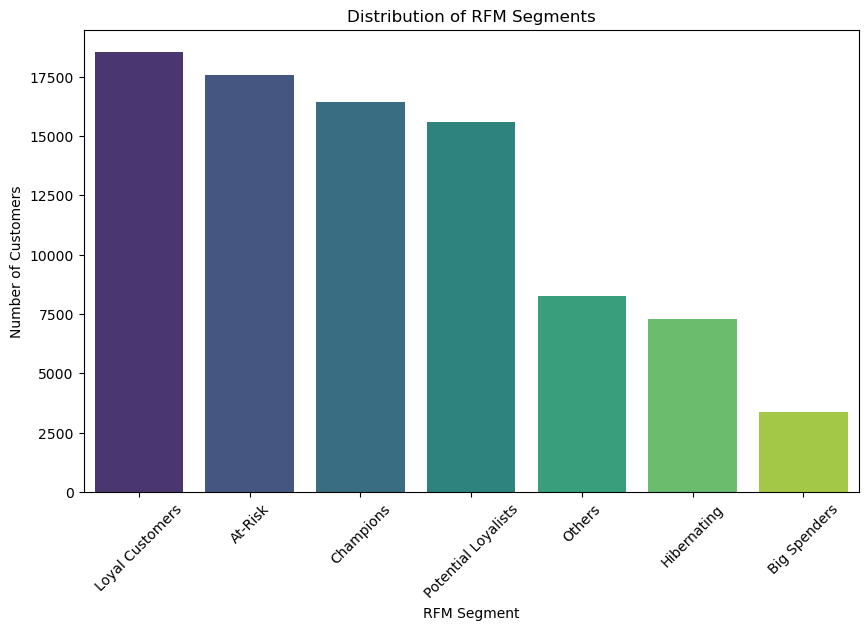

In [18]:


# Plot the distribution of RFM segments
plt.figure(figsize=(10, 6))
sns.countplot(x='RFM_Segment', data=rfm_table, palette='viridis', order=rfm_table['RFM_Segment'].value_counts().index)
plt.title('Distribution of RFM Segments')
plt.xlabel('RFM Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()


- `Champions`: Customers who score high on all three dimensions (Recency, Frequency, Monetary). These are your best customers.


- `At-Ris`k: Customers who score low on all three dimensions. They haven't purchased recently, don't purchase frequently, and don't spend much.

- `Loyal Customers:` Customers with a high recency score. They have purchased recently, indicating strong engagement.

- `Potential Loyalists:` Customers with a high frequency score. They purchase often and could become loyal customers.

- `Big Spenders:` Customers with a high monetary score. They spend a lot when they do purchase.

- `Hibernating:` Customers with a low recency score. They haven't purchased recently.

- `Others:` Customers who do not fall into any of the above categories.

### prediction to detect multiclass customer

In [26]:
df_labeled = df_data_clean.merge(rfm_table[['Customer_ID', 'RFM_Segment']], on='Customer_ID', how='inner')
print(df_labeled.columns) 
# drop some columns 
df_labeled = df_labeled.drop(["Email", "Name", "Address", "Phone", "Zipcode"], axis=1)

# Convert Date to datetime
df_labeled['Date'] = pd.to_datetime(df_labeled['Date'])

# Extract features from Date
df_labeled['Day'] = df_labeled['Date'].dt.day
df_labeled['Weekday'] = df_labeled['Date'].dt.weekday
df_labeled['Quarter'] = df_labeled['Date'].dt.quarter


# Extract hour from Time
df_labeled['Hour'] = pd.to_datetime(df_labeled['Time']).dt.hour

# Interaction between Age and Total_Purchases


Index(['Transaction_ID', 'Customer_ID', 'Name', 'Email', 'Phone', 'Address',
       'City', 'State', 'Zipcode', 'Country', 'Age', 'Gender', 'Income',
       'Customer_Segment', 'Date', 'Year', 'Month', 'Time', 'Total_Purchases',
       'Amount', 'Total_Amount', 'Product_Category', 'Product_Brand',
       'Product_Type', 'Feedback', 'Shipping_Method', 'Payment_Method',
       'Order_Status', 'Ratings', 'products', 'RFM_Segment'],
      dtype='object')


In [27]:
# drop the columns 
df_labeled.columns

Index(['Transaction_ID', 'Customer_ID', 'City', 'State', 'Country', 'Age',
       'Gender', 'Income', 'Customer_Segment', 'Date', 'Year', 'Month', 'Time',
       'Total_Purchases', 'Amount', 'Total_Amount', 'Product_Category',
       'Product_Brand', 'Product_Type', 'Feedback', 'Shipping_Method',
       'Payment_Method', 'Order_Status', 'Ratings', 'products', 'RFM_Segment',
       'Day', 'Weekday', 'Quarter', 'Hour'],
      dtype='object')

0                      Nike
1                      Sony
2                Home Depot
3                      Zara
4                     Pepsi
                ...        
300744                 Nike
300745                Pepsi
300746    Bed Bath & Beyond
300747                Pepsi
300748                 Sony
Name: Product_Brand, Length: 300749, dtype: object

In [23]:
df_labeled["Age_Total_Purchases"].head()

0     63.0
1    133.0
2    120.0
3    184.0
4    232.0
Name: Age_Total_Purchases, dtype: float64

In [21]:
df_labeled.head()

,Transaction_ID,Customer_ID,Name,Email,Phone,Address,City,State,Zipcode,Country,...,Product_Category,Product_Brand,Product_Type,Feedback,Shipping_Method,Payment_Method,Order_Status,Ratings,products,RFM_Segment
0,8691788.0,37249.0,Michelle Harrington,Ebony39@gmail.com,1.414787e+09,3959 Amanda Burgs,Dortmund,Berlin,77985.0,Germany,...,Clothing,Nike,Shorts,Excellent,Same-Day,Debit Card,Shipped,5.0,Cycling shorts,Champions
1,2322638.0,37249.0,Mr. Charles Scott,Joseph46@gmail.com,3.464625e+09,3393 Victor Street,Portsmouth,England,99762.0,UK,...,Electronics,Sony,Smartphone,Good,Express,PayPal,Delivered,3.0,Sony Xperia,Champions
2,1814136.0,37249.0,David Kelly,Kathryn94@gmail.com,3.407689e+09,54848 Daniel Pass,Saskatoon,Ontario,65852.0,Canada,...,Home Decor,Home Depot,Furniture,Average,Express,PayPal,Delivered,2.0,Bed,Champions
3,4895457.0,37249.0,Sheryl Wright,Christine32@gmail.com,6.094710e+09,4652 Bradley Fords,Hamilton,Ontario,84617.0,Canada,...,Clothing,Zara,Shirt,Excellent,Express,Cash,Shipped,5.0,Polo shirt,Champions
4,5836653.0,37249.0,Sierra Mann,Melinda29@gmail.com,6.823401e+09,37838 Bailey Centers,Gold Coast,New South Wales,55493.0,Australia,...,Grocery,Pepsi,Water,Average,Same-Day,PayPal,Shipped,2.0,Flavored water,Champions


### visualization on Seasonal sales distribution:

In [89]:
# Filter for only USA data
df_usa = df_labeled[df_labeled['Country'] == 'USA']
df_not_usa = df_labeled[df_labeled['Country'] != 'USA']

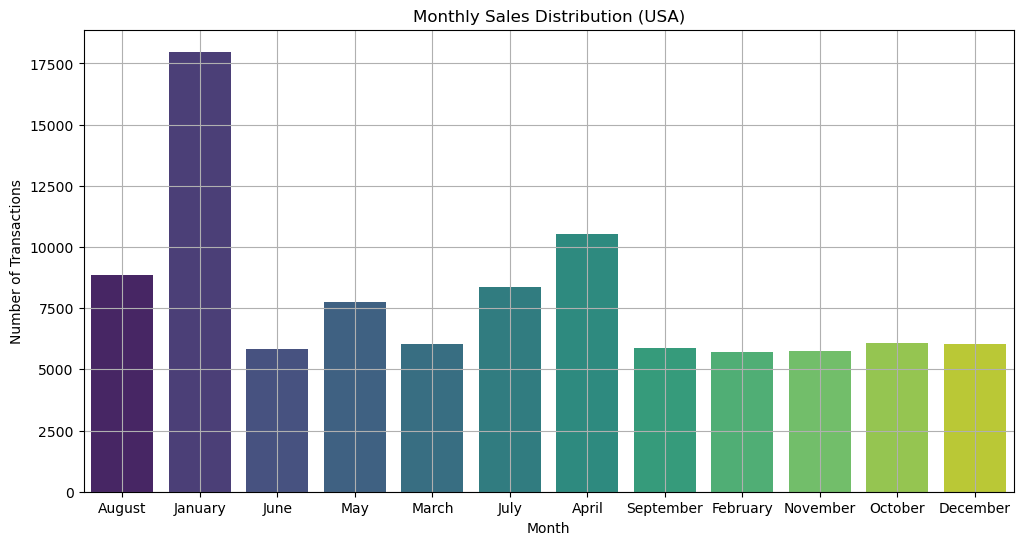

In [78]:
# Monthly Sales Distribution for USA
plt.figure(figsize=(12, 6))
sns.countplot(data=df_usa, x='Month', palette='viridis')
plt.title('Monthly Sales Distribution (USA)')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.show()


/var/folders/qc/8812nyc533x05df3fh9jggnm0000gn/T/ipykernel_40295/3713919510.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_usa['Date'] = pd.to_datetime(df_usa['Date'])
/var/folders/qc/8812nyc533x05df3fh9jggnm0000gn/T/ipykernel_40295/3713919510.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_usa['Month'] = df_usa['Date'].dt.month_name()


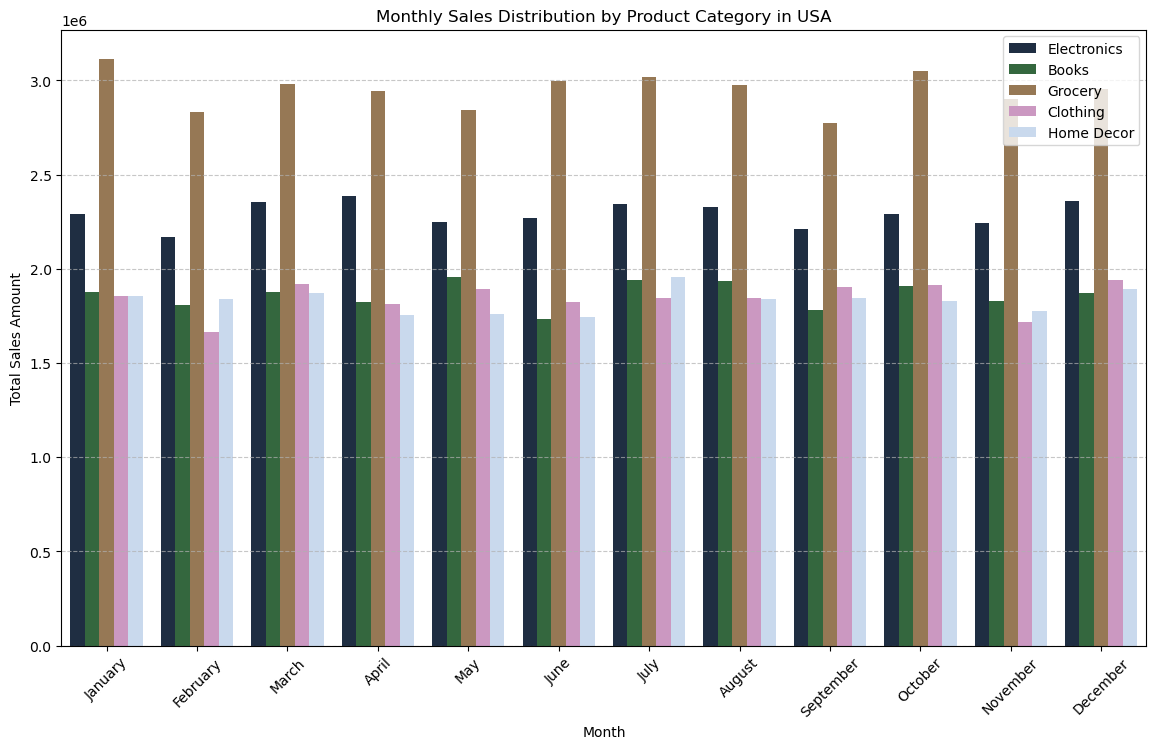

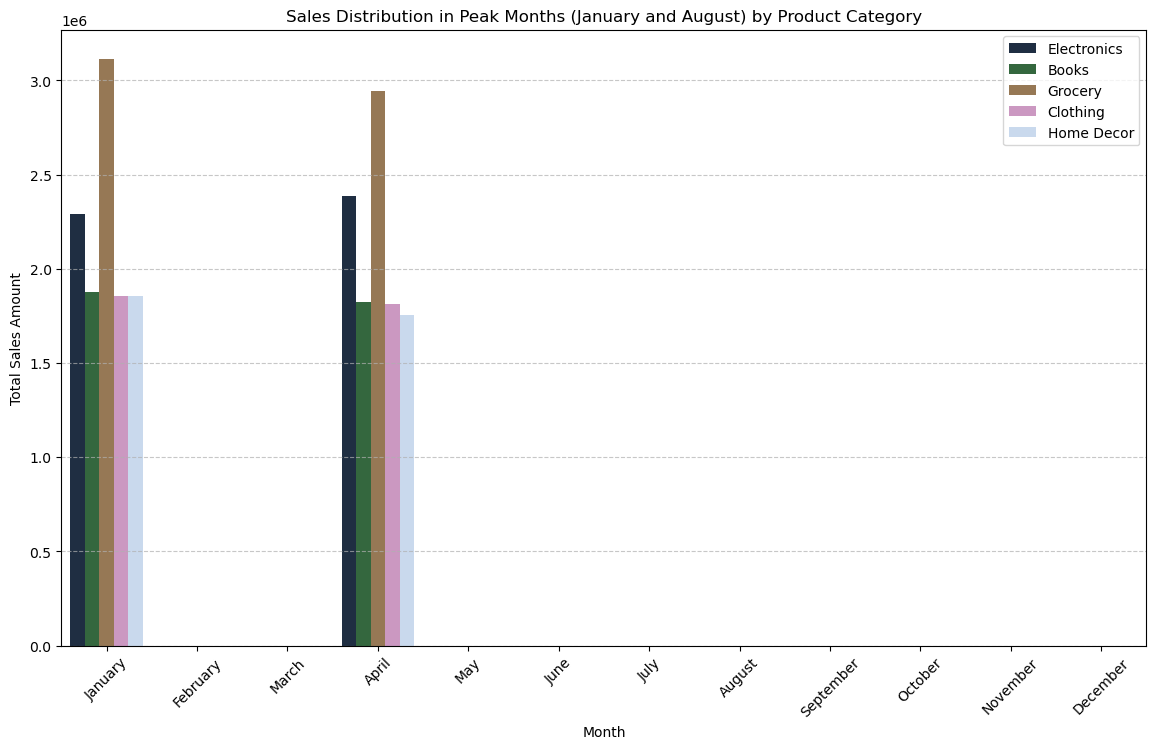

Top Product Categories in January:
   Product_Category  Total_Amount
40          Grocery  3.114303e+06
28      Electronics  2.290261e+06
4             Books  1.876509e+06
52       Home Decor  1.855505e+06
16         Clothing  1.854894e+06


Top Product Categories in April:
   Product_Category  Total_Amount
36          Grocery  2.946059e+06
24      Electronics  2.385606e+06
0             Books  1.823168e+06
12         Clothing  1.814709e+06
48       Home Decor  1.752312e+06




In [90]:
### try to investigate which product is the most popular during january and april in USA 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_labeled is the dataframe containing the relevant data
# Convert 'Date' to datetime format if not already done
df_usa['Date'] = pd.to_datetime(df_usa['Date'])
df_usa['Month'] = df_usa['Date'].dt.month_name()

# Aggregate sales data by product category and month
category_month_sales = df_usa.groupby(['Product_Category', 'Month']).agg({'Total_Amount': 'sum'}).reset_index()

# Sort months for better visualization
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
category_month_sales['Month'] = pd.Categorical(category_month_sales['Month'], categories=month_order, ordered=True)
category_month_sales = category_month_sales.sort_values('Month')

# Visualize total sales per category for each month
plt.figure(figsize=(14, 8))
sns.barplot(x='Month', y='Total_Amount', hue='Product_Category', data=category_month_sales, palette="cubehelix")
plt.title('Monthly Sales Distribution by Product Category in USA')
plt.xlabel('Month')
plt.ylabel('Total Sales Amount')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Detailed analysis for peak months (January and August)
peak_months = ['January', 'April']
peak_month_sales = category_month_sales[category_month_sales['Month'].isin(peak_months)]

plt.figure(figsize=(14, 8))
sns.barplot(x='Month', y='Total_Amount', hue='Product_Category', data=peak_month_sales, palette='cubehelix')
plt.title('Sales Distribution in Peak Months (January and August) by Product Category')
plt.xlabel('Month')
plt.ylabel('Total Sales Amount')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Show top contributing categories for peak months
for month in peak_months:
    month_data = peak_month_sales[peak_month_sales['Month'] == month]
    top_categories = month_data.sort_values(by='Total_Amount', ascending=False).head(5)
    print(f"Top Product Categories in {month}:")
    print(top_categories[['Product_Category', 'Total_Amount']])
    print("\n")


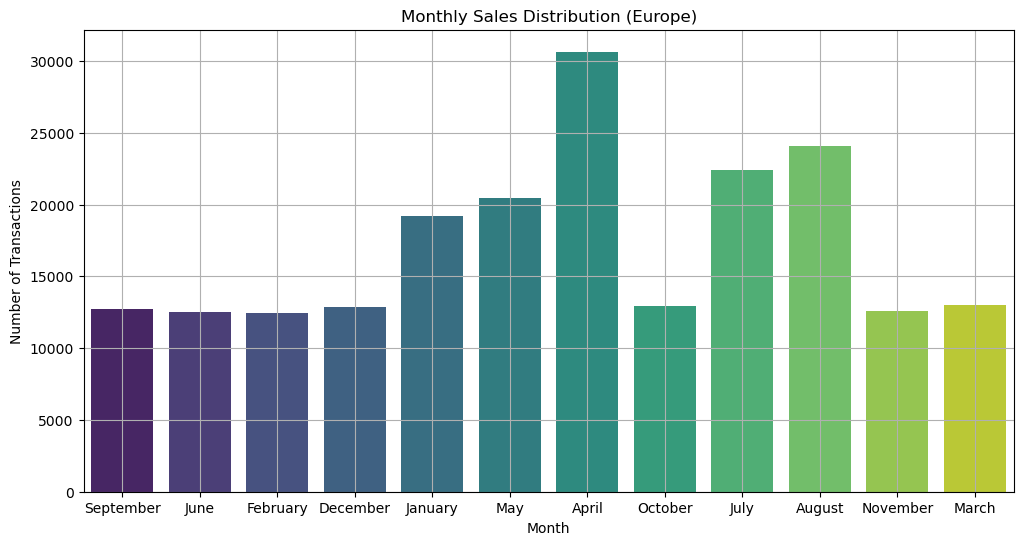

In [91]:
# Monthly Sales Distribution for USA
plt.figure(figsize=(12, 6))
sns.countplot(data=df_not_usa, x='Month', palette='viridis')
plt.title('Monthly Sales Distribution (Europe)')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.show()


#### *Top Categories in Europe and USA:*

`In Europe`, the top product categories during peak months (`April and August`) include Electronics, Grocery, Clothing, Books, and Home Decor.

`In the USA`, the top product categories during peak months (`January and April`) are Grocery, Electronics, Books, Home Decor, and Clothing.

**Consistent High-Performing Categories:**

Electronics and Grocery consistently appear as top categories in both Europe and the USA.

Books, Clothing, and Home Decor are also significant contributors across different months and regions.


#### Marketing Strategy Recommendations:

**Targeted Promotions for Top Categories:**

`Electronics and Grocery:` Since these categories consistently perform well, focus on targeted promotions, discounts, and special offers. Highlight new arrivals, bestsellers, and exclusive deals in these categories.

Use data-driven marketing to personalize recommendations and offers based on past purchase behavior in these categories.

**Seasonal Campaigns:**

- `Europe (April and August)`: Develop marketing campaigns around these peak months. Highlight Electronics and Grocery during these times, emphasizing new tech releases in April and back-to-school or summer essentials in August.

- `USA (January and April):` Focus on post-holiday sales and new year promotions in January, with a strong emphasis on Grocery and Electronics. In April, leverage spring sales, promoting home improvement (Home Decor) and summer prep products.

/var/folders/qc/8812nyc533x05df3fh9jggnm0000gn/T/ipykernel_40295/3365361448.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_usa['Date'] = pd.to_datetime(df_not_usa['Date'])
/var/folders/qc/8812nyc533x05df3fh9jggnm0000gn/T/ipykernel_40295/3365361448.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_usa['Month'] = df_not_usa['Date'].dt.month_name()


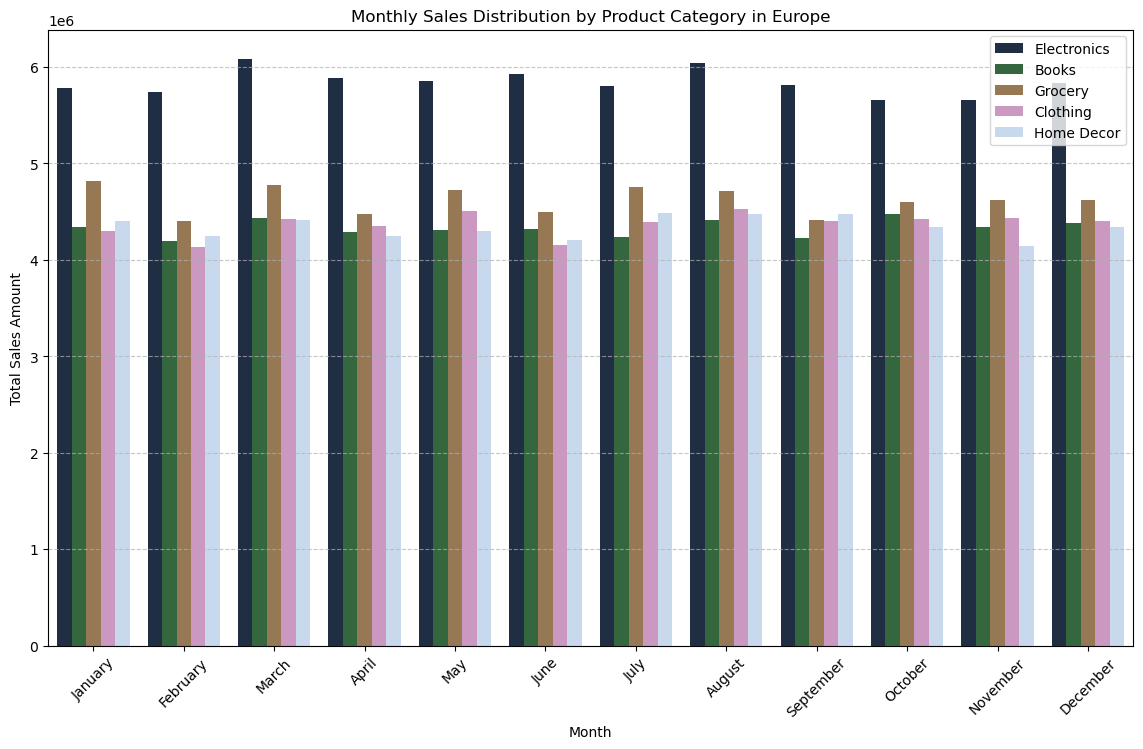

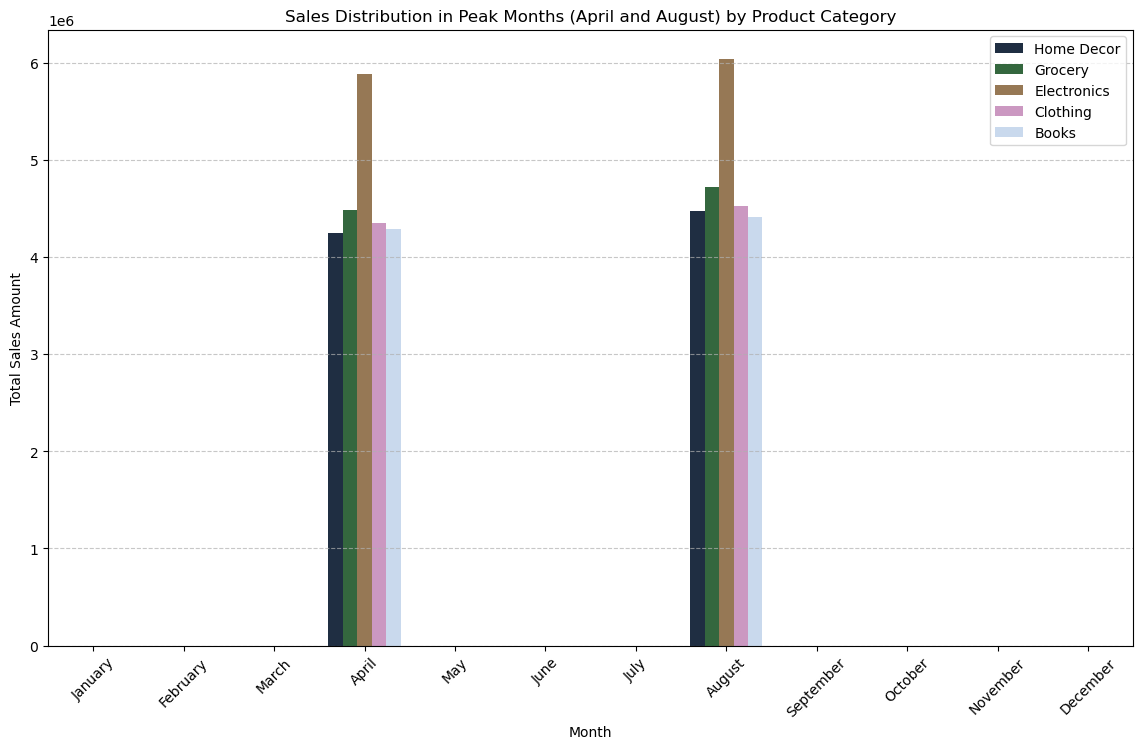

Top Product Categories in April:
   Product_Category  Total_Amount
24      Electronics  5.884706e+06
36          Grocery  4.479933e+06
12         Clothing  4.346641e+06
0             Books  4.292827e+06
48       Home Decor  4.243492e+06


Top Product Categories in August:
   Product_Category  Total_Amount
25      Electronics  6.039675e+06
37          Grocery  4.717920e+06
13         Clothing  4.528143e+06
49       Home Decor  4.476943e+06
1             Books  4.409535e+06




In [81]:
### try to investigate which product is the most popular during january and april in USA 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_labeled is the dataframe containing the relevant data
# Convert 'Date' to datetime format if not already done
df_not_usa['Date'] = pd.to_datetime(df_not_usa['Date'])
df_not_usa['Month'] = df_not_usa['Date'].dt.month_name()

# Aggregate sales data by product category and month
category_month_sales = df_not_usa.groupby(['Product_Category', 'Month']).agg({'Total_Amount': 'sum'}).reset_index()

# Sort months for better visualization
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
category_month_sales['Month'] = pd.Categorical(category_month_sales['Month'], categories=month_order, ordered=True)
category_month_sales = category_month_sales.sort_values('Month')

# Visualize total sales per category for each month
plt.figure(figsize=(14, 8))
sns.barplot(x='Month', y='Total_Amount', hue='Product_Category', data=category_month_sales, palette="cubehelix")
plt.title('Monthly Sales Distribution by Product Category in Europe')
plt.xlabel('Month')
plt.ylabel('Total Sales Amount')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Detailed analysis for peak months (January and August)
peak_months = ['April', 'August']
peak_month_sales = category_month_sales[category_month_sales['Month'].isin(peak_months)]

plt.figure(figsize=(14, 8))
sns.barplot(x='Month', y='Total_Amount', hue='Product_Category', data=peak_month_sales, palette='cubehelix')
plt.title('Sales Distribution in Peak Months (April and August) by Product Category')
plt.xlabel('Month')
plt.ylabel('Total Sales Amount')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Show top contributing categories for peak months
for month in peak_months:
    month_data = peak_month_sales[peak_month_sales['Month'] == month]
    top_categories = month_data.sort_values(by='Total_Amount', ascending=False).head(5)
    print(f"Top Product Categories in {month}:")
    print(top_categories[['Product_Category', 'Total_Amount']])
    print("\n")


## feature engineering

In [29]:
df_labeled = pd.get_dummies(df_labeled, columns=['Gender', 'Income', 'Customer_Segment', 'City', 'State', 'Country', 'Product_Category', 'Product_Brand', 'Product_Type', 'Shipping_Method', 'Payment_Method', 'Order_Status'], drop_first=True)

# Interaction between Age and Total_Amount
df_labeled['Age_Total_Amount'] = df_labeled['Age'] * df_labeled['Total_Amount']

# Aggregated features: mean, sum, and count of purchases and amount by Customer_ID
agg_features = df_labeled.groupby('Customer_ID').agg({
    'Total_Purchases': ['mean', 'sum', 'count'],
    'Total_Amount': ['mean', 'sum']
}).reset_index()

# Flatten the multi-level columns
agg_features.columns = ['_'.join(col).strip() for col in agg_features.columns.values]
agg_features.rename(columns={'Customer_ID_': 'Customer_ID'}, inplace=True)

# Merge aggregated features back to the main dataframe
df_labeled = df_labeled.merge(agg_features, on='Customer_ID', how='left')

# Calculate Customer Lifetime Value (CLV) as Total_Amount / Number of Purchases
df_labeled['CLV'] = df_labeled['Total_Amount_sum'] / df_labeled['Total_Purchases_count']

# Create segments based on Total_Amount
df_labeled['Segment'] = pd.qcut(df_labeled['Total_Amount'], 4, labels=['Low', 'Medium', 'High', 'Very High'])

# Additional segmentation based on CLV
df_labeled['CLV_Segment'] = pd.qcut(df_labeled['CLV'], 4, labels=['Low CLV', 'Medium CLV', 'High CLV', 'Very High CLV'])

In [35]:
df_labeled["CLV"]

0         1297.077906
1         1297.077906
2         1297.077906
3         1297.077906
4         1297.077906
             ...     
300744    1141.543602
300745    2585.513129
300746     389.466325
300747     634.061736
300748    3720.100576
Name: CLV, Length: 300749, dtype: float64

In [30]:
df_labeled.shape

(300749, 283)

In [31]:
df_labeled.to_csv('/Users/smsultanmahmudrahat/Downloads/department/ADS_last_Project/project/data/classifer_detection.csv')

In [32]:
df_labeled= pd.read_csv("/Users/smsultanmahmudrahat/Downloads/department/ADS_last_Project/project/data/classifer_detection.csv")

In [34]:
df_labeled["RFM_Segment"].value_counts()

Champions              91293
Potential Loyalists    77391
Loyal Customers        52683
At-Risk                27676
Hibernating            21031
Others                 19295
Big Spenders           11380
Name: RFM_Segment, dtype: int64

In [4]:

from sklearn.preprocessing import StandardScaler
df_labeled["Date"] = pd.to_datetime(df_labeled["Date"])


import pandas as pd
from imblearn.over_sampling import SMOTE
from collections import Counter


scaler = StandardScaler()
numerical_features = df_labeled.select_dtypes(include=['float64', 'int64']).columns
df_labeled[numerical_features] = scaler.fit_transform(df_labeled[numerical_features])

# Check for and handle any remaining non-numeric columns
non_numeric_columns = df_labeled.select_dtypes(include=['object', 'datetime']).columns
df_labeled.drop(columns=non_numeric_columns, inplace=True)


# Separate features and target variable
X = df_labeled.drop('Is_Champion', axis=1)
y = df_labeled['Is_Champion']

# Apply SMOTE
smote = SMOTE(sampling_strategy='minority')
X_smote, y_smote = smote.fit_resample(X, y)

print(f'Original dataset shape: {Counter(y)}')
print(f'SMOTE dataset shape: {Counter(y_smote)}') 


Original dataset shape: Counter({0: 209456, 1: 91293})
SMOTE dataset shape: Counter({1: 209456, 0: 209456})
